In [545]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

import numpy as np
import math
import pandas as pd
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 30)
pd.options.display.float_format = '{:,}'.format


In [546]:
# FUNCTIONS

def enum_category(label):
    num=0
    if label == 'Poor' : num =1
    elif label == 'Fair': num = 2
    elif label == 'Average': num = 3
    elif label == 'Good': num = 4
    elif label == 'Very Good': num = 5
    else: return label
    
    return int(num)

def log_and_normalize (data, log, norm_type):
    if log == 'log':
        data = np.log(data) 
    if norm_type == 1:
        data = (data-np.mean(data))/np.std(data)  # std normalisation
    elif norm_type == 2:
        data = (data-min(data))/(max(data)-min(data))      #  min_max_min
    elif norm_type == 3:
        data = (data-np.mean(data))/(max(data)-min(data))  # mean norm
    
    return data    

def hot_encode (data, directions):
    if directions == 'yes':
        data = pd.get_dummies(data, prefix=data.name[:3], drop_first=True)
    return data

In [547]:
df=pd.read_csv('data/kc_house_data.csv', index_col=0)

# initial cleaning operations (splitting , etc)

df["grade"]=df["grade"].map(lambda x: x.split()[0]).astype(int)
df['condition'] = df['condition'].apply(enum_category)


In [567]:
# Prepairing data

df['yr_renovated'].fillna(value=df['yr_built'],inplace=True)
df['yr_renovated'] = np.where(df['yr_renovated'] == 0, df['yr_built'], df['yr_renovated'])

df['waterfront'].fillna(value='NO',inplace=True)

#NEW FEATURES

df['lat_range']=pd.cut(df['lat'], 30)
df['long_range']=pd.cut(df['long'], 30)
df['coord_range']=np.array(zip(df['lat_range'],df['long_range']))
df['decade']=pd.cut(df['yr_built'], 12)

#FILTER
df=df[df['yr_built']>1980]

In [568]:
data_fin=pd.DataFrame([])

price=df[["price"]]

#cont=["sqft_living", 'sqft_lot', 'sqft_living15']

cont=["sqft_living", 'sqft_lot']
cat=[ 'grade', 'zipcode', 'view', 'waterfront','yr_built']


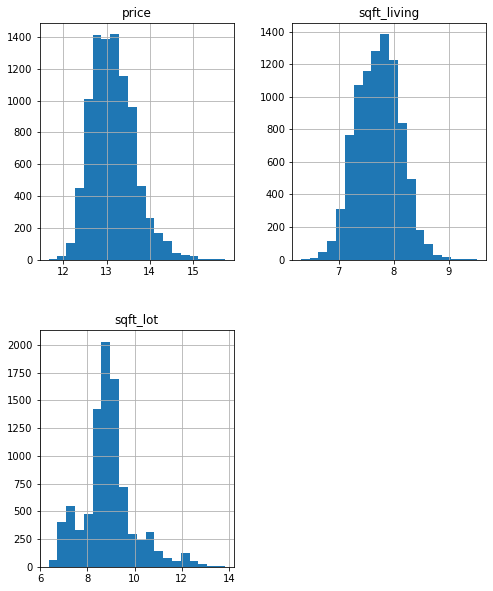

In [569]:
# Log transform and normalize
price=log_and_normalize(price, 'log', 0)
for col in cont:
    data_fin[col]=log_and_normalize(df[col], 'log', 0)


pd.concat([price, data_fin], axis=1).hist(figsize=(8,10), bins=20);


In [570]:
# One hot encode categoricals
for col in cat:
    new_cols=hot_encode(df[col], 'yes')
    data_fin = pd.concat([data_fin, new_cols], axis=1)

data_fin = pd.concat([price, data_fin], axis=1)

In [571]:
# Create OLS linear model
pred=data_fin.drop(columns=["price"]).copy()

pred_int = sm.add_constant(pred)
model = sm.OLS(price,pred_int).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     843.7
Date:                Sun, 27 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:21:44   Log-Likelihood:                 4682.3
No. Observations:                9029   AIC:                            -9127.
Df Residuals:                    8910   BIC:                            -8281.
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.1759      0.074    110.967      0.000       8.031       8.320
sqft_living       0.5124      0.007     71.113      0.000       0.498       0.526
sqft_lot          0.0771      0.002     31.353      0.000       0.072       0.082
gra_6            -0.2283      0.058     -3.962      0.000      -0.341      -0.115
gra_7            -0.1903      0.056     -3.415      0.001      -0.300      -0.081
gra_8            -0.1105      0.056     -1.978      0.048      -0.220      -0.001
gra_9            -0.0148      0.056     -0.264      0.792      -0.125       0.095
gra_10            0.0777      0.056      1.376      0.169      -0.033       0.188
gra_11            0.2134      0.057      3.741      0.000       0.102       0.325
gra_12            0.3424      0.059      5.778      0.000       0.226       0.459
gra_13            0.6598      0.078      8.497      0.000       0.508       0.812
zip_98002         0.0156      0.021      0.730      0.465      -0.026       0.058
zip_98003         0.0323      0.017      1.863      0.062      -0.002       0.066
zip_98004         1.1140      0.019     59.636      0.000       1.077       1.151
zip_98005         0.7716      0.032     24.181      0.000       0.709       0.834
zip_98006         0.6670      0.015     44.262      0.000       0.637       0.697
zip_98007         0.7086      0.026     27.264      0.000       0.658       0.760
zip_98008         0.7508      0.035     21.486      0.000       0.682       0.819
zip_98010         0.1638      0.022      7.284      0.000       0.120       0.208
zip_98011         0.4498      0.018     24.931      0.000       0.414       0.485
zip_98014         0.2443      0.020     12.150      0.000       0.205       0.284
zip_98019         0.2883      0.016     18.113      0.000       0.257       0.319
zip_98022         0.0561      0.018      3.177      0.001       0.021       0.091
zip_98023        -0.0031      0.015     -0.208      0.835      -0.032       0.026
zip_98024         0.4266      0.027     15.999      0.000       0.374       0.479
zip_98027         0.5376      0.014     37.669      0.000       0.510       0.566
zip_98028         0.4297      0.017     25.470      0.000       0.397       0.463
zip_98029         0.6240      0.014     45.284      0.000       0.597       0.651
zip_98030         0.0462      0.016      2.966      0.003       0.016       0.077
zip_98031         0.1064      0.016      6.662      0.000       0.075       0.138
zip_98032         0.0388      0.039      0.989      0.323      -0.038       0.116
zip_98033         0.8045      0.015     53.799      0.000       0.775       0.834
zip_98034         0.5889      0.016     36.922      0.000       0.558       0.620
zip_98038         0.1556      0.013     12.401      0.000       0.131       0.180
zip_98039         1.2836      0.034     37.243   

In [572]:
coef_df=model.params.reset_index()
coef_df.columns=["Column","Value"]

In [573]:
def get_coeff(year,zipcode,grade, water,view):
    intercept=coef_df[coef_df['Column'] == "const"]["Value"].tolist()[0]
    sqft_living_coef=coef_df[coef_df['Column'] == "sqft_living"]["Value"].tolist()[0]
    
    try:
        sqft_lot_coef=coef_df[coef_df['Column'] == "sqft_lot"]["Value"].tolist()[0]
    except:
        sqft_lot_coef=0   
        
    try:
        sqft_living15_coef=coef_df[coef_df['Column'] == "sqft_living15"]["Value"].tolist()[0]
    except:
        sqft_living15_coef=0   
        
    if water == 'WATERFRONT':
        water_coef=coef_df[coef_df['Column'] == "wat_YES"]["Value"].tolist()[0]
    else:
        water_coef=0
        
    if len(str(year)) != 4: 
        year_coef=0
    else:
        try: year_coef=coef_df[coef_df['Column'].str.endswith(str(year))]["Value"].tolist()[0]
        except: year_coef=0
            
    if len(str(zipcode)) != 5: 
        zipcode_coef=0
    else:
        try: zipcode_coef=coef_df[coef_df['Column'].str.endswith(str(zipcode))]["Value"].tolist()[0]
        except: zipcode_coef=0
            
    if len(str(grade))!=1 and len(str(grade))!=2: 
        grade_coef=0
    else:
        try: grade_coef=coef_df[coef_df['Column'].str.endswith('gra_'+str(grade))]["Value"].tolist()[0]
        except: grade_coef=0
    
    if view  not in ['NONE','FAIR','GOOD','EXCELLENT']: 
        view_coef=0
    else:
        try: view_coef=coef_df[coef_df['Column'].str.endswith(view)]["Value"].tolist()[0]
        except: view_coef=0

    return intercept, sqft_living_coef, year_coef, zipcode_coef, grade_coef,  water_coef, view_coef, sqft_lot_coef,sqft_living15_coef




In [574]:
test_results=[]
for i in range(2000):
    X=np.array(df[['sqft_living','yr_built','zipcode','grade','waterfront','view', 'sqft_lot','sqft_living15','price']].sample())[0]
    sqft_living,year,zipcode,grade,water,view,sqft_lot,sqft_living15,price=X

    b0,b1,b2,b3,b4,b5,b6,b7,b8 = get_coeff(year=year, zipcode=zipcode, grade=grade, water=water, view=view)

    y=round( np.exp(b0 + b1*np.log(sqft_living) + b2 + b3 + b4 + b5 + b6 + b7*np.log(sqft_lot)+b8*np.log(sqft_living15)) )
    miss=np.abs(100-y/price*100)
    test_results.append(miss)

avg_miss=sum(test_results)/len(test_results)
print (avg_miss)



10.802745719807607


In [440]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display



In [295]:



X=np.array(df[['sqft_living','yr_built','zipcode','grade','waterfront','view', 'sqft_lot','sqft_living15','price']].sample())[0]
sqft_living,year,zipcode,grade,water,view,sqft_lot,sqft_living15,price=X

b0,b1,b2,b3,b4,b5,b6,b7,b8 = get_coeff(year=year, zipcode=zipcode, grade=grade, water=water, view=view)

In [578]:
df['sqft_lot'].median()

7120.0

2005